<a href="https://colab.research.google.com/github/arthijayaraman-lab/CREASE-2D/blob/main/CREASE%20Tutorials/Genetic_Algorithm_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#@title import all necessary files
import numpy as np
import sys
import xgboost as xgb
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from skimage.metrics import structural_similarity as ssim
import gdown
import warnings
warnings.filterwarnings('ignore')

In [17]:
#@title ML model loading and support functions
def load_data(file_path):
    """
    Load the scattering profile from a text file.

    Parameters:
    - file_path (str): The path to the file containing the data.

    Returns:
    - np.ndarray or None: The loaded and adjusted data if successful, else None.
    """
    try:
        datafile = np.loadtxt(file_path, delimiter=',')

        if datafile.shape != (numq,numtheta) and not np.mod(np.add(datafile.shape,(-1,-1)),(numq-1,numtheta-1)).any():
            origshape=datafile.shape;
            increments=np.int_(np.divide(np.add(datafile.shape,(-1,-1)),(numq-1,numtheta-1)));
            datafile=datafile[0:origshape[0]:increments[0],0:origshape[1]:increments[1]]
        return datafile
    except Exception as e:
        print("Error loading data file:", str(e))
        return None

def load_dataset(file_path):
    """
    Load structural features from a text file.

    Parameters:
    - file_path (str): The path to the file containing the dataset.

    Returns:
    - np.ndarray or None: The loaded dataset if successful, else None.
    """
    try:
        datafile = np.loadtxt(file_path, delimiter=',')
        return datafile
    except Exception as e:
        print("Error loading data file:", str(e))
        return None

def calculate_fitness(data1, data2):
    """
   Calculate fitness scorecbetween any two matrices using Structural Similarity Index (SSIM).

   Parameters:
   - data1 (np.ndarray): First matrix.
   - data2 (np.ndarray): Second matrix.

   Returns:
   - float or None: The SSIM score if successful, else None.
   """
    datarange = np.max([np.max(data1),np.max(data2)]) - np.min([np.min(data1),np.min(data2)])
    try:
        score = ssim(data1, data2,data_range=datarange)
        #score = r2_score(data1, data2)
        return score
    except Exception as e:
        print("Error calculating SSIM:", str(e))
        return None

class ProfileGenerator:
    """
    A class for generating and visualizing profiles using an XGBoost model.

    Parameters:
        - model_file (str): Path to the XGBoost model file in JSON format.
        - log_q (np.ndarray): Logarithmic values of q.
        - theta (np.ndarray): Values of theta.

        Methods:
        - load_model(): Load the XGBoost model from the specified file.
        - create_combined_data(struc_features): Combine structural features with log_q and theta.
        - genes_to_struc_features(genevalues): Convert gene values to structural features.
        - generate_profile(combined_data): Generate a scattering profile using the loaded XGBoost model.
        - visualize_profile(profile, fname): Visualize the scattering profile.

    Note: Call load_model() before using other methods.
    """
    def __init__(self, model_file, log_q, theta):
        self.model_file = model_file
        self.log_q = log_q
        self.theta = theta
    def load_model(self):
        try:
            # Load the XGBoost model from the JSON file
            self.xgboost_model = xgb.Booster(model_file=self.model_file)
            return True
        except Exception as e:
            print("Error loading XGBoost model:", str(e))
            return False

    def create_combined_data(self, struc_features):
        qtheta = np.array([(logq, th) for logq in self.log_q for th in self.theta])
        shape_struc_features=struc_features.shape
        struc_features=struc_features.transpose()
        struc_features=struc_features.reshape((1,shape_struc_features[1],shape_struc_features[0]))
        shape_qtheta=qtheta.shape
        qtheta=qtheta.reshape((shape_qtheta[0],shape_qtheta[1],1))
        repeated_struc_features = np.repeat(struc_features, repeats=shape_qtheta[0], axis=0)
        repeated_qtheta = np.repeat(qtheta, repeats=shape_struc_features[0], axis=2)
        combined_data = np.hstack((repeated_struc_features,repeated_qtheta))
        return combined_data

    def genes_to_struc_features(self, genevalues):
        #Volume fraction
        phi = genevalues[:,0]/2;
        #Radius
        logmuR = np.log(3)+genevalues[:,1]*np.log(10)
        logsigR = (1-np.abs((2*genevalues[:,1]-1)))*np.log(10)/6*genevalues[:,2]
        meanR = np.exp(logmuR+0.5*logsigR**2)
        sigmaR = np.sqrt((np.exp(logsigR**2)-1)*np.exp(2*logmuR+logsigR**2))
        #AspectRatios
        logmuG = (2*genevalues[:,3]-1)*np.log(10)
        logsigG = (1-np.abs((2*genevalues[:,3]-1)))*np.log(10)/3*genevalues[:,4]
        meanG = np.exp(logmuG+0.5*logsigG**2)
        sigmaG = np.sqrt((np.exp(logsigG**2)-1)*np.exp(2*logmuG+logsigG**2))
        #Kappa
        kappaexp=np.less_equal(genevalues[:,5],0.25)*((genevalues[:,5]/0.25)*(-1+10)-10) +\
                 np.greater(genevalues[:,5],0.25)*np.less_equal(genevalues[:,5],0.5)*(((genevalues[:,5]-0.25)/0.25)*(0+1)-1) +\
                 np.greater(genevalues[:,5],0.5)*np.less_equal(genevalues[:,5],0.75)*(((genevalues[:,5]-0.5)/0.25)*(1-0)) +\
                 np.greater(genevalues[:,5],0.75)*(((genevalues[:,5]-0.75)/0.25)*(10-1)+1)
        kappa = 10**kappaexp
        struc_features = np.vstack((meanR, sigmaR, meanG, sigmaG, kappa, phi))
        struc_features=struc_features.transpose()
        return struc_features

    def generate_profile(self, combined_data):
        if not hasattr(self, 'xgboost_model'):
            print("Model not loaded. Please call 'load_model()' first.")
            return None
        feature_names = ["MeanR", "StdR", "MeanG", "StdG", "Kappa", "Volume_Fraction", "log_q", "theta"]
        dmatrix = xgb.DMatrix(combined_data, feature_names=feature_names)
        generated_profile = self.xgboost_model.predict(dmatrix)
        return generated_profile

    def visualize_profile(self, profile,fname=None):
        if profile is None:
            return
        plt.figure(figsize = (10,10))
        plt.imshow(profile, cmap='inferno')
        plt.xticks(np.linspace(0,numtheta,4),["0","60","120","180"])
        plt.yticks(np.linspace(0,numq,6),["$10^3$","$10^2$","$10^1$","$10^0$","$10^{-1}$","$10^{-2}$"])
        plt.xlabel("$\\theta (\degree)$",fontsize=20)
        plt.ylabel("$q$",fontsize=20)
        if fname:
            plt.savefig(fname)
        plt.show()

In [39]:
#@title Genetic Algorithm Implementation

def generateallprofiles(gatable,profile_generator):
    """
    Generate profiles for all individuals in the genetic table .

    Parameters:
        - gatable (np.ndarray): Genetic table containing gene values.
        - profile_generator (ProfileGenerator): An instance of the ProfileGenerator class.

    Returns:
        - np.ndarray: Generated profiles for all individuals.
    """
    popsize=gatable.shape[0]
    indscore=gatable.shape[1]-1
    profile_generator.load_model()
    strucfeatures = profile_generator.genes_to_struc_features(gatable[:,0:indscore])
    combined_data = profile_generator.create_combined_data(strucfeatures)
    shape_combined_data=combined_data.shape
    generated_profiles=np.zeros((numq,numtheta,popsize))
    for n in range(popsize):
        inputdata=combined_data[:,:,n].reshape(shape_combined_data[0:2])
        generated_profile=profile_generator.generate_profile(inputdata)
        generated_profile=generated_profile.reshape((numq,numtheta))
        generated_profiles[:,:,n]=generated_profile
    return generated_profiles

def updateallfitnesses(gatable,profiles,inputdata):
    """
    Update fitness scores for all individuals in the genetic table.

     Parameters:
         - gatable (np.ndarray): Genetic table containing gene values and fitness scores.
         - profiles (np.ndarray): Generated profiles for all individuals.
         - inputdata (np.ndarray): Input data for fitness calculation.

    Returns:
        - np.ndarray: Updated genetic table with fitness scores.
    """
    popsize=gatable.shape[0]
    indscore=gatable.shape[1]-1
    for n in range(popsize):
         gatable[n,indscore]=calculate_fitness(inputdata, profiles[:,:,n])
    return gatable

def generate_children(parents,popsize):
    """
    Generate children by crossover from parent individuals.

    Parameters:
        - parents (np.ndarray): Parent individuals.

    Returns:
        - np.ndarray or None: Children generated by crossover.
    """
    size_parents = parents.shape
    numparents = size_parents[0]
    numchildren = popsize - numparents
    if numchildren % 2 !=0:
        print('numchildren must be even!')
        return None
    numpairs = int(numchildren/2)
    numcols = size_parents[1]
    #Using rank weighting for parent selection
    randnumbersparent = np.random.rand(numchildren)
    #each two consecutive rows mate
    parentindices = np.int64(np.floor((2*numparents+1-np.sqrt(4*numparents*(1+numparents)*(1-randnumbersparent)+1))/2))
    children = parents[parentindices,:]
    # perform crossover
    crossoverpoint = np.random.rand(numpairs)*6
    crossoverindex = np.int64(np.floor(crossoverpoint))
    crossovervalue = crossoverpoint - crossoverindex
    for n in range(numpairs):
        originalchild1 = children[2*n,:]
        originalchild2 = children[2*n+1,:]
        ind=crossoverindex[n]
        val=crossovervalue[n]
        newchild1 = np.hstack((originalchild1[0:ind],originalchild2[ind:]))
        newchild2 = np.hstack((originalchild2[0:ind],originalchild1[ind:]))
        newchild1[ind]= originalchild1[ind]*val+originalchild2[ind]*(1-val)
        newchild2[ind]= originalchild2[ind]*val+originalchild1[ind]*(1-val)
        newchild1[ind]=np.maximum(np.minimum(newchild1[ind],1),0)
        newchild2[ind]=np.maximum(np.minimum(newchild2[ind],1),0)
        #np.clip(newchild1[ind], 0, 1, out=newchild1[ind])
        #np.clip(newchild2[ind], 0, 1, out=newchild2[ind])
        children[2*n,:]=newchild1
        children[2*n+1,:]=newchild2
    return children

def applymutations(gatable,numelites):
    """
    Apply mutations to the genetic table.

    Parameters:
        - gatable (np.ndarray): Genetic table containing gene values.
        - numelites (int): Number of elite individuals.

    Returns:
        - np.ndarray: Genetic table with mutations applied.
    """
    shape_gatable = gatable.shape
    mutationhalfstepsize = 0.15
    mutationflag = np.less_equal(np.random.rand(shape_gatable[0],shape_gatable[1]),mutationrate)
    mutationvalues = np.random.uniform(-mutationhalfstepsize,mutationhalfstepsize,(shape_gatable[0],shape_gatable[1]))*mutationflag
    mutationvalues[0:numelites,:] = 0 #elite individuals are not mutated
    gatable = gatable + mutationvalues
    np.clip(gatable, 0, 1, out=gatable)
    return gatable

def plot_fitness(fitness_scores, ax, fname):
    """
    Plot fitness scores over generations.

    Parameters:
        - fitness_scores (np.ndarray): Array containing fitness scores over generations.
        - fname (str or None): File name for saving the plot. If None, show the plot.

    Returns:
        - Plot
    """
    line1 = ax.errorbar(fitness_scores[:,0],fitness_scores[:,1],yerr=fitness_scores[:,2], fmt='o', color='red', linewidth=1)
    line2, = ax.plot(fitness_scores[:,0],fitness_scores[:,3],'k-',label='best fitness',linewidth=2)
    line3, = ax.plot(fitness_scores[:,0],fitness_scores[:,4],'b-',label='worst fitness',linewidth=2)
    #line3, = ax.plot(fitness_scores[:,0],fitness_scores[:,3])
    # setting title
    plt.autoscale(enable=True,axis='both')
    #ax.set(xlim=(0,numgens),ylim=(0.7,0.9))
    plt.title("Fitness vs Generation", fontsize=20)
    plt.xlabel("Generation", fontsize=20)
    plt.ylabel("Fitness Value (SSIM)", fontsize=20)
    if fname is not None:
        plt.savefig(fname)
    plt.show()

Downloading...
From: https://drive.google.com/uc?id=1Q9ztgJ5mXpqixjasceUYC2_zHBIwm73O
To: /content/model
100%|██████████| 55.9M/55.9M [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rzu5QfS3-6cmFLf_NYBZRXk69tDjrGxs
To: /content/scatteringProfile
100%|██████████| 120k/120k [00:00<00:00, 17.1MB/s]


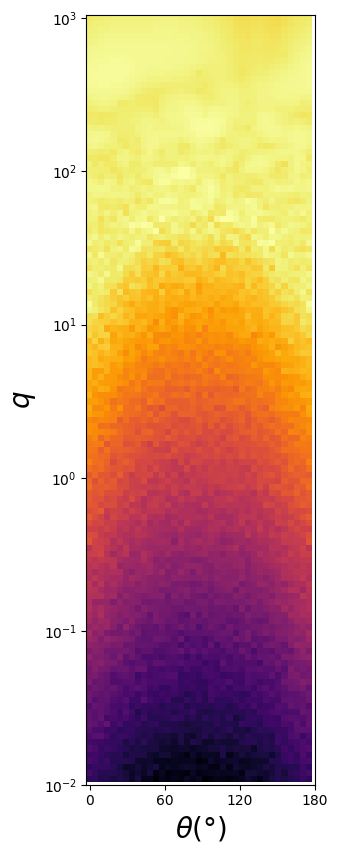

Original structural features: [8.49, 2.3, 0.28, 0.05, 5900000000.0, 0.45]


In [32]:
#declare global variables and set paths
numq, numtheta=126, 37
log_q = np.linspace(-2, 3, numq);
theta = np.linspace(0, np.pi,numtheta);

#ML model
model_file_id = '1Q9ztgJ5mXpqixjasceUYC2_zHBIwm73O'
model_file = gdown.download(id=model_file_id, output='model', quiet=False)

#Test Scattering file
test_scattering_profile_id = '1Rzu5QfS3-6cmFLf_NYBZRXk69tDjrGxs'
scatteringProfile = gdown.download(id=test_scattering_profile_id, output='scatteringProfile', quiet=False)
input_data = load_data(scatteringProfile)

#Original structural features to compare with optimzied
original_struc_features = [8.49,2.3,0.28,0.05,5.9e+09,0.45]

profile_generator = ProfileGenerator(model_file, log_q, theta)
profile_generator.visualize_profile(input_data)
print("Original structural features:", original_struc_features)

Best Structural Features after Generation 0:
[[1.08499777e+01 2.63918605e-01 5.67434536e-01 3.09938270e-01
  4.29558315e+07 4.25040179e-01]]


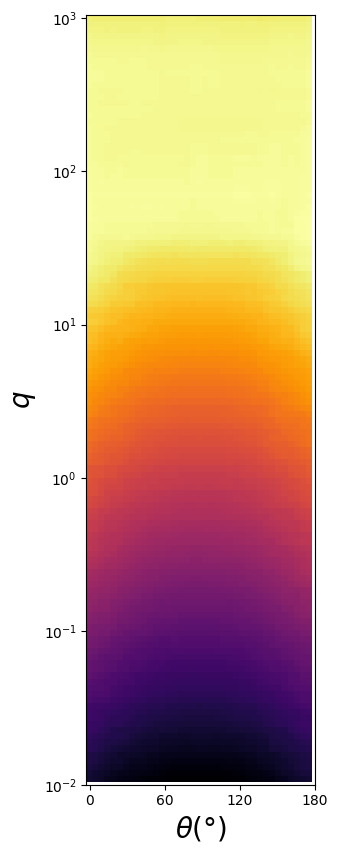

In [33]:
#@title Best sample and its structural features shown in 0th generation
#Generate Initial Population
initial_population_size=200
pop_size=100
num_genes=6
ga_table = np.random.rand(initial_population_size,7)
initialprofiles = generateallprofiles(ga_table,profile_generator)
ga_table = updateallfitnesses(ga_table, initialprofiles, input_data)
tableindices = np.flipud(ga_table[:,num_genes].argsort()) #sort by the descending fitness value
ga_table = ga_table[tableindices[0:pop_size]]
np.savetxt('gen0.txt', ga_table, delimiter=',')

best_structural_features = ga_table[0, :num_genes].reshape(1, -1)
best_structural_features = profile_generator.genes_to_struc_features(best_structural_features)

print("Best Structural Features after Generation 0:")
print(best_structural_features)

currentprofiles = initialprofiles[:,:,tableindices[0:pop_size]]
profile_generator.visualize_profile(currentprofiles[:,:,0],'bestaftergen0.png')

Generation: 0. Best fitness: 0.8563184434539265. Average fitness: 0.8473129198515895.
Generation: 10. Best fitness: 0.8563184434539265. Average fitness: 0.8500764956751468.
Generation: 20. Best fitness: 0.8563184434539265. Average fitness: 0.8496117411387907.
Generation: 30. Best fitness: 0.8563184434539265. Average fitness: 0.8500662612639013.
Generation: 40. Best fitness: 0.8563184434539265. Average fitness: 0.8491887842451308.
Generation: 50. Best fitness: 0.8563184434539265. Average fitness: 0.8489368961734236.


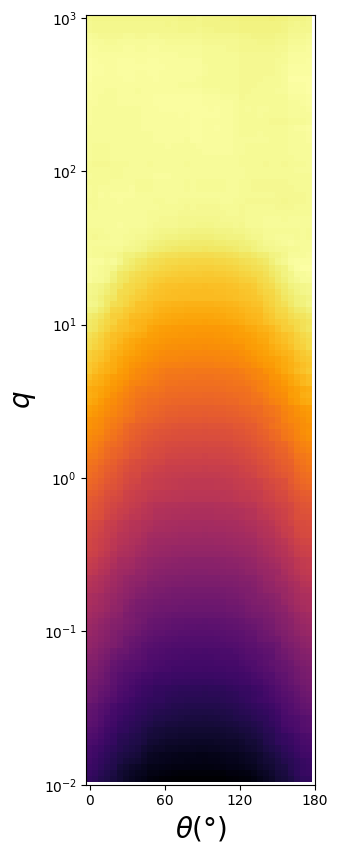

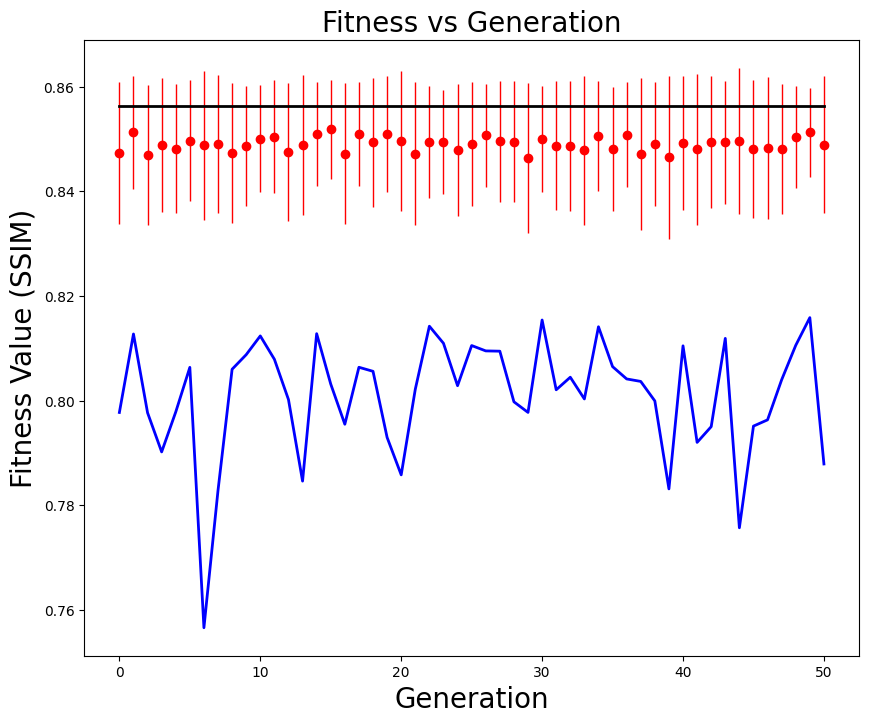

In [40]:
# GA steps

num_generations=50
numparents=30 # keep 30% of the population for mating
numelites=2
mutationrate=0.1

meanfitness = np.mean(ga_table[:,6])
stddevfitness = np.std(ga_table[:,6])
bestfitness = ga_table[0,6]
worstfitness = ga_table[-1,6]
diversitymetric = np.mean(np.sum((ga_table-np.mean(ga_table,axis=0))**2,axis=1))
print('Generation: '+ str(0) +'. Best fitness: ' + str(bestfitness) + '. Average fitness: ' + str(meanfitness) + '.')
#print('The diversity metric is '+str(diversitymetric))

#fitness scores initialization
fitness_scores = np.array([[0,meanfitness,stddevfitness,bestfitness,worstfitness]])
#figure, ax = plt.subplots(figsize=(10,8))
#plot_fitness(fitness_scores, ax, None)

#Evolutionary process loop
struc_featurestable = profile_generator.genes_to_struc_features(ga_table[:,0:6])
struc_featurestable = np.vstack((np.ones([1,num_genes])*0,struc_featurestable))
evolvedstrucfeatures=struc_featurestable.reshape((pop_size+1,1,num_genes))

for currentgen in range(1,num_generations+1):
    parents = ga_table[0:numparents,:]
    children = generate_children(parents,pop_size)
    ga_table = np.vstack((parents,children))
    ga_table = applymutations(ga_table,numelites)
    currentprofiles = generateallprofiles(ga_table,profile_generator)
    ga_table = updateallfitnesses(ga_table, currentprofiles, input_data)
    tableindices = np.flipud(ga_table[:,num_genes].argsort()) #sort by the descending fitness value
    ga_table = ga_table[tableindices]
    meanfitness = np.mean(ga_table[:,6])
    stddevfitness = np.std(ga_table[:,6])
    bestfitness = ga_table[0,6]
    worstfitness = ga_table[-1,6]
    diversitymetric = np.mean(np.sum((ga_table-np.mean(ga_table,axis=0))**2,axis=1))
    fitness_scores=np.append(fitness_scores,[[currentgen,meanfitness,stddevfitness,bestfitness,worstfitness]],axis=0)
    mutationrate = -np.log10(diversitymetric)*0.1
    if currentgen%10 == 0:
        print('Generation: '+ str(currentgen) +'. Best fitness: ' + str(bestfitness) + '. Average fitness: ' + str(meanfitness) + '.')
        struc_featurestable = profile_generator.genes_to_struc_features(ga_table[:,0:6])
        struc_featurestable = np.vstack((np.ones([1,num_genes])*currentgen,struc_featurestable))
        evolvedstrucfeatures=np.hstack((evolvedstrucfeatures,struc_featurestable.reshape((pop_size+1,1,num_genes))))
    if currentgen%50 == 0 and currentgen != 0:
        profile_generator.visualize_profile(currentprofiles[:,:,0],'bestaftergen'+str(currentgen)+'.png')
        figure1, ax1 = plt.subplots(figsize=(10,8))
        plot_fitness(fitness_scores, ax1,'fitnessplot.png')
        np.savetxt('gen'+str(currentgen)+'.txt', ga_table, delimiter=',')


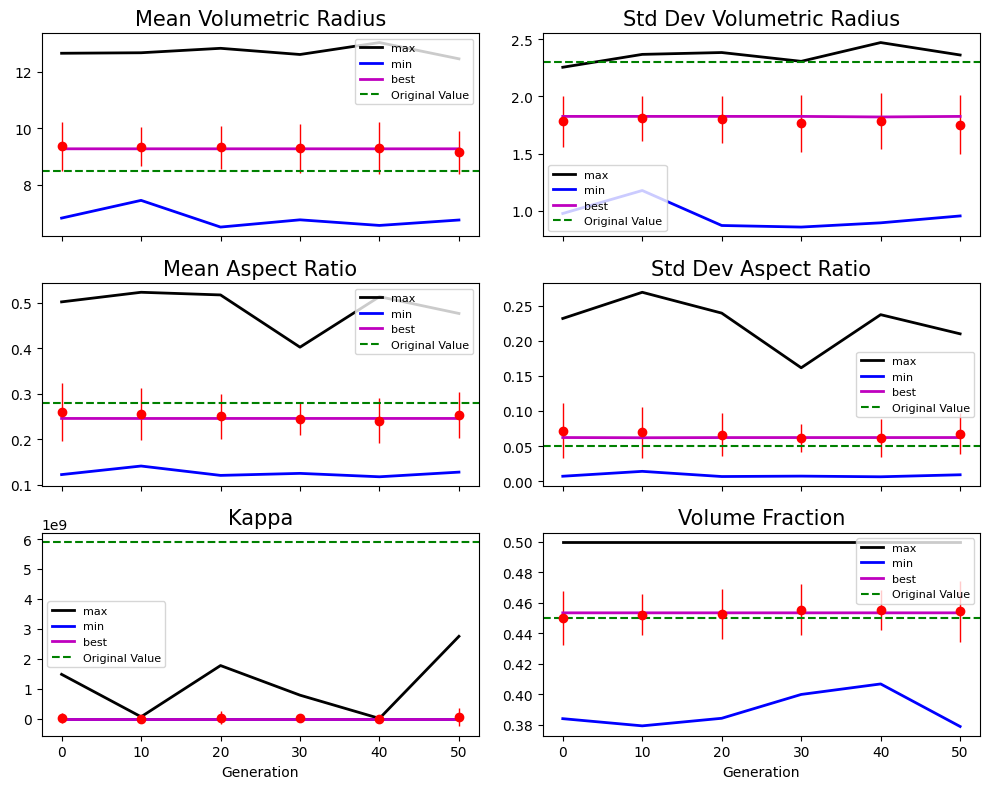

In [42]:
features = []
evolvedstrucfeatures = np.swapaxes(evolvedstrucfeatures,0,1)
for i in range(num_genes):
    feature = np.vstack((
        evolvedstrucfeatures[:, 0, i],  # Generation number
        np.mean(evolvedstrucfeatures[:, 1:(pop_size + 1), i], axis=1),  # Mean
        np.std(evolvedstrucfeatures[:, 1:(pop_size + 1), i], axis=1),   # Std Dev
        np.max(evolvedstrucfeatures[:, 1:(pop_size + 1), i], axis=1),   # Max
        np.min(evolvedstrucfeatures[:, 1:(pop_size + 1), i], axis=1),   # Min
        evolvedstrucfeatures[:, 1, i]  # Best individual
    )).T  # Transpose to match the desired shape
    features.append(feature)
titles = [
    "Mean Volumetric Radius",
    "Std Dev Volumetric Radius",
    "Mean Aspect Ratio",
    "Std Dev Aspect Ratio",
    "Kappa",
    "Volume Fraction"
]

all_struc_indices = [2, 3, 4, 5, 6, 1]

# Create subplots
figure2, ax2 = plt.subplots(3, 2, sharex=True, figsize=(10, 8))

# Iterate over each feature and its corresponding subplot
for i, ax in enumerate(ax2.flat):
    feature = features[i]  # Get the corresponding feature from the `features` list
    ax.errorbar(feature[:, 0], feature[:, 1], yerr=feature[:, 2], fmt='o', color='red', linewidth=1)
    ax.plot(feature[:, 0], feature[:, 3], 'k-', label='max', linewidth=2)
    ax.plot(feature[:, 0], feature[:, 4], 'b-', label='min', linewidth=2)
    ax.plot(feature[:, 0], feature[:, 5], 'm-', label='best', linewidth=2)
    ax.axhline(y=original_struc_features[i], color='g', linestyle='--', label='Original Value')
    ax.set_title(titles[i], fontsize=15)
    ax.legend(fontsize=8)

    if i >= 4:
        ax.set_xlabel("Generation", fontsize=10)

plt.tight_layout()
plt.savefig('evolvedstrucfeatures.png')
plt.show()
